In [23]:
import numpy as np
import pandas as pd
from astropy.io import fits
import matplotlib.pyplot as plt
from ipynb.fs.full.explore_data import fold_data

### [data](http://archive.stsci.edu/), [table of labelled data properties](http://exoplanetarchive.ipac.caltech.edu/)

In [24]:
# load data
koi = pd.read_csv('../KOI.csv')
sysid = 6022556
obsq1 = fits.open(f'../data/{sysid}/kplr00{sysid}-2009166043257_llc.fits')

In [3]:
# get time and flux data
spec_cols = np.array((obsq1[1].data.TIME-min(obsq1[1].data.TIME),obsq1[1].data.PDCSAP_FLUX)).transpose()
data = pd.DataFrame(spec_cols, columns=['time','flux'])
data.head()

,time,flux
0,0.000000,8591.976562
1,0.020434,8587.601562
2,0.040869,8595.933594
3,0.061303,8586.216797
4,0.081738,8587.034180


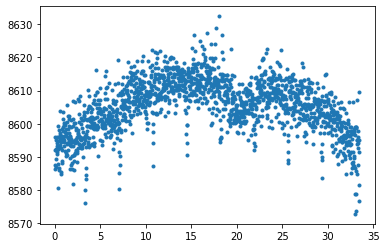

In [4]:
plt.plot(data['time'],data['flux'],'.');

/home/ngrewal/MLP_Kepler/useful_files/explore_data.ipynb:123: RuntimeWarning: invalid value encountered in remainder
  "      <th>koi_slogg_err2</th>\n",


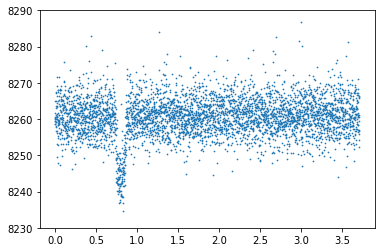

In [5]:
obsq3 = fits.open('../data/6022556/kplr006022556-2009350155506_llc.fits')
times, flux = fold_data(obsq3,6022556,koi);

In [6]:
# fit a curve to this then find the goodness of fit/chi?

### trying LTSM

In [81]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras_balanced_batch_generator import make_generator
from tensorflow.keras.layers import Input,Dense,Embedding,LSTM,TimeDistributed,Activation,Dropout
from sklearn.metrics import confusion_matrix

"We can divide the sequence into multiple input/output patterns called samples, where three time steps are used as input and one time step is used as output for the one-step prediction that is being learned." (flux in our case)

In [118]:
# split data into train and test (the function is 2D but we only need 1D, hence the repetition)
flux = data.flux[~np.isnan(data.flux)]
xtrain, xtest, xtrain, xtest = train_test_split(flux, flux, test_size = 0.3)

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps                                # find the end of this pattern
        if end_ix > len(sequence)-1:                        # check if we are beyond the sequence
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # gather input and output parts of the pattern
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)                               

# choose a number of time steps
n_steps = 5
# split into samples
X, y = split_sequence(list(xtrain), n_steps)
X_test, y_test = split_sequence(list(xtest), n_steps)
print('',X[0], y[0],'\n', X_test[0],y_test[0])

 [8596.0859375  8609.90332031 8610.98242188 8605.28710938 8604.65625   ] 8597.74609375 
 [8608.88574219 8608.77832031 8588.31933594 8604.63769531 8600.68457031] 8610.9169921875


In [119]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))

# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=200, verbose=0)

# demonstrate prediction
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
x_pred = model.predict(X_test, verbose=0)

In [120]:
# find standard deviation of difference between observed and expected
np.std(x_pred - y_test)

8.6684665715848